# **Non-negative Matrix Factorization (NMF)**

-Family of linear algebra algorithms for identifying the latent structure in data represented as a non-negative matrix.

-The only difference is that LDA adds a Dirichlet prior on top of the data generating process, meaning NMF qualitatively leads to worse mixtures. It fixes values for the probability vectors of the multinomials, whereas LDA allows the topics and words themselves to vary.

-Thus, in cases where we believe that the topic probabilities should remain fixed per document (often times unlikely)—or in small data settings in which the additional variability coming from the hyper priors is too much—NMF performs better.

In [ ]:
import pandas as pd
import os

In [ ]:
# need this code snippet in each notebook to mount the google drive
from google.colab import drive  
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
os.chdir("/content/gdrive/My Drive/Colab Notebooks/CPTx Alerts/")
!ls

alerts2.csv


In [ ]:
for df_alerts in pd.read_csv("alerts2.csv", iterator=True, chunksize=50000):
    break 
df_alerts.shape

(6411, 5)

In [ ]:
# For loading entire dataset, RAM issues
df_alerts = pd.read_csv("alerts2.csv",low_memory=False)
df_alerts.shape

In [ ]:
# find unique classification ids
set(df_alerts.classification)

{0}

Cleaning Unstructured Text Data

The most important thing we need to do to help our topic modelling algorithm is to pre-clean up the alerts. As you look back at the alerts you may notice that they are very untidy, with non-standard English, capitalisation, links, hashtags, @users and punctuation and emoticons everywhere. If we are going to be able to apply topic modelling we need to remove most of this and massage our data into a more standard form before finally turning it into vectors.

First we will start with imports for this specific cleaning task.

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In the cell below I provide some functions to remove non text characters. We will also remove repetitions and mentions in the corpus. We remove these because it is unlikely that they will help us form meaningful topics.

In [ ]:
def remove_users(alerts):
    '''Takes a string and removes retweet and @user information'''
    alerts = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', alerts) # remove repeated alerts
    alerts = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', alerts) 
    return alerts

In [ ]:
import nltk
import re
nltk.download("popular")
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_alert(alerts, bigrams=False):
    alerts = alerts.lower() # lower case
    alerts = re.sub('['+my_punctuation + ']+', ' ', alerts) # strip punctuation
    alerts = re.sub('\s+', ' ', alerts) #remove double spacing
    alerts = re.sub('([0-9]+)', '', alerts) # remove numbers
    alerts_token_list = [word for word in alerts.split(' ')
                            if word not in my_stopwords] # remove stopwords

    alerts_token_list = [word_rooter(word) if '#' not in word else word
                        for word in alerts_token_list] # apply word rooter
    if bigrams:
        alerts_token_list = alerts_token_list+[alerts_token_list[i]+'_'+alerts_token_list[i+1]
                                            for i in range(len(alerts_token_list)-1)]
    alerts = ' '.join(alerts_token_list)
    return alerts

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [ ]:
df_alerts['clean_alerts'] = df_alerts.message.apply(clean_alert,bigrams=False)
df = df_alerts
df.shape

(6411, 6)

In [ ]:
df.head()

,sensor_type,message,priority,blocked,classification,clean_alerts
3000000,ISENSOR,51056 VID1029 Qualys Vulnerability Scanner Hea...,4,1,0,vid quali vulner scanner header inbound
3000001,ISENSOR,51056 VID1029 Qualys Vulnerability Scanner Hea...,4,1,0,vid quali vulner scanner header inbound
3000002,ISENSOR,51056 VID1029 Qualys Vulnerability Scanner Hea...,4,1,0,vid quali vulner scanner header inbound
3000003,ISENSOR,32036 VID12927 Generic XSS Protection Inbound,3,3,0,vid gener xss protect inbound
3000004,ISENSOR,51056 VID1029 Qualys Vulnerability Scanner Hea...,4,1,0,vid quali vulner scanner header inbound


# **Applying LDA Topic Modelling:**

To turn the text into a matrix*, where each row in the matrix encodes which words appeared in each individual alert. We will also filter the words max_df=0.9 means we discard any words that appear in >90% of alerts. In this dataset I don’t think there are any words that are that common but it is good practice. We will also filter words using min_df=25, so words that appear in less than 25 alerts will be discarded. We discard high appearing words since they are too common to be meaningful in topics. We discard low appearing words because we won’t have a strong enough signal and they will just introduce noise to our model.

We usually turn text into a sparse matrix, to save on space, but since our tweet database it small we should be able to use a normal matrix.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# the vectorizer object will be used to transform text to vector form
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer
#vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=None,stop_words=['microsoft','securework']) # this works much better

# apply transformation
tf = vectorizer.fit_transform(df['clean_alerts']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

# **Topic extraction with Non-negative Matrix Factorization**
Non-negative Matrix Factorization is applied with two different objective functions: the Frobenius norm, and the generalized Kullback-Leibler divergence. The latter is equivalent to Probabilistic Latent Semantic Indexing.

In [ ]:
from sklearn.decomposition import NMF
number_of_topics = 5
beta_loss = 'kullback-leibler'  #String must be in {‘frobenius’, ‘kullback-leibler’, ‘itakura-saito’}
nmf = NMF(n_components=number_of_topics, random_state=1,
          beta_loss=beta_loss, solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5)

In [ ]:
nmf.fit(tf)

NMF(alpha=0.1, beta_loss='kullback-leibler', init=None, l1_ratio=0.5,
    max_iter=1000, n_components=5, random_state=1, shuffle=False, solver='mu',
    tol=0.0001, verbose=0)

Next we will want to inspect our topics that we generated and try to extract meaningful information from them.

Below I have written a function which takes in our model object model, the order of the words in our matrix tf_feature_names and the number of words we would like to show. Use this function, which returns a dataframe, to show you the topics we created. Remember that each topic is a list of words/tokens and weights

In [ ]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [ ]:
no_top_words = 10
display_topics(nmf, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,quali,3.7,http,2.6,user,2.0,attempt,1.3,soc,2.6
1,vulner,3.7,execut,2.2,agent,2.0,access,0.9,test,2.6
2,header,3.7,file,2.1,detect,1.9,window,0.9,alert,2.6
3,scanner,3.7,download,2.1,outbound,1.4,smb,0.9,zyxel,0.0
4,inbound,3.1,request,0.4,possibl,1.4,share,0.9,heartbeat,0.0
5,execut,0.0,suspici,0.4,goldenspi,1.3,unicod,0.9,gener,0.0
6,gener,0.0,type,0.3,malwar,1.3,ipc,0.9,get,0.0
7,http,0.0,sent,0.3,ryeol,1.3,inbound,0.6,goldenspi,0.0
8,html,0.0,content,0.3,zgrab,0.8,cve,0.5,handl,0.0
9,htaccess,0.0,plain,0.3,zmeu,0.4,gener,0.5,header,0.0


# **Word Cloud:**

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. Word clouds are widely used for analyzing data from social network websites such as twitter.

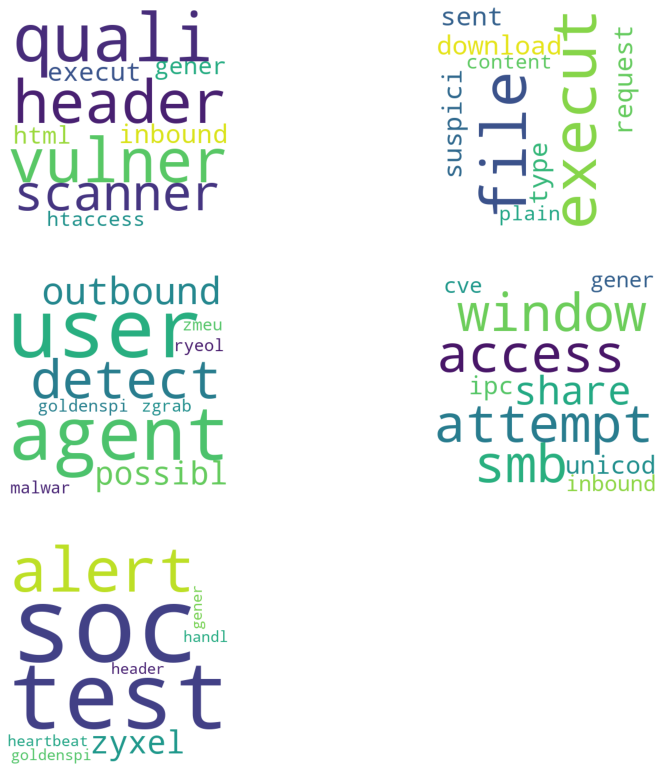

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
df = display_topics(nmf, tf_feature_names, no_top_words)
df2 = df.iloc[:, ::2] # skip every other column of topic weights
fig = plt.figure(figsize=(14,14))
for i in range(number_of_topics):
    ax = fig.add_subplot(3,2,i+1)
    comment_words = '' 
    stopwords = set(STOPWORDS)
    for val in df2.iloc[:, i]:      
        val = str(val) 
        # split the value 
        tokens = val.split()     
        comment_words += " ".join(tokens)+" " 
    wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
    
    ax.imshow(wordcloud)
    ax.axis('off')